In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.ops import unary_union

# --- 1. Paths ---
S2_b04 = '../Ejercicio3/SENTINEL-2_B04_10m.jp2'
S2_b08 = '../Ejercicio3/SENTINEL-2_B08_10m.jp2'
barrios = '../Ejercicio3/barrios/barrios.shp'

# --- 2. Leer shapefile ---
barrios_gdf = gpd.read_file(barrios)

print("CRS de barrios:", barrios_gdf.crs)

# --- 3. Reproyectar a CRS de Sentinel (si es necesario) ---
with rasterio.open(S2_b04) as src:
    raster_crs = src.crs

if barrios_gdf.crs != raster_crs:
    print(f"Reproyectando de {barrios_gdf.crs} → {raster_crs}")
    barrios_gdf = barrios_gdf.to_crs(raster_crs)

# --- 4. Crear geometría combinada y buffer ---
union = unary_union(barrios_gdf.geometry)

# Buffer de 1000 metros (solo si CRS está en metros)
margen_metros = 1000
union_buffer = union.buffer(margen_metros)

# Corregir posibles geometrías inválidas
union_buffer = gpd.GeoSeries([union_buffer]).buffer(0).iloc[0]

# --- 5. Función de recorte robusta ---
def recortar_raster(ruta_entrada, geometria, ruta_salida):
    with rasterio.open(ruta_entrada) as src:
        # Recortar (crop)
        out_image, out_transform = mask(src, [geometria], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(ruta_salida, "w", **out_meta) as dest:
            dest.write(out_image)

# --- 6. Aplicar recorte ---
recortar_raster(S2_b04, union_buffer, 'data/S2_B04_CABA_buffer.tif')
recortar_raster(S2_b08, union_buffer, 'data/S2_B08_CABA_buffer.tif')

print("✅ Recorte completado sin errores.")




CRS de barrios: EPSG:4326
Reproyectando de EPSG:4326 → EPSG:32721
✅ Recorte completado sin errores.


C:\Users\User\AppData\Local\Temp\ipykernel_8380\956278687.py:18: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((b8 + b4) == 0, np.nan, (b8 - b4) / (b8 + b4))


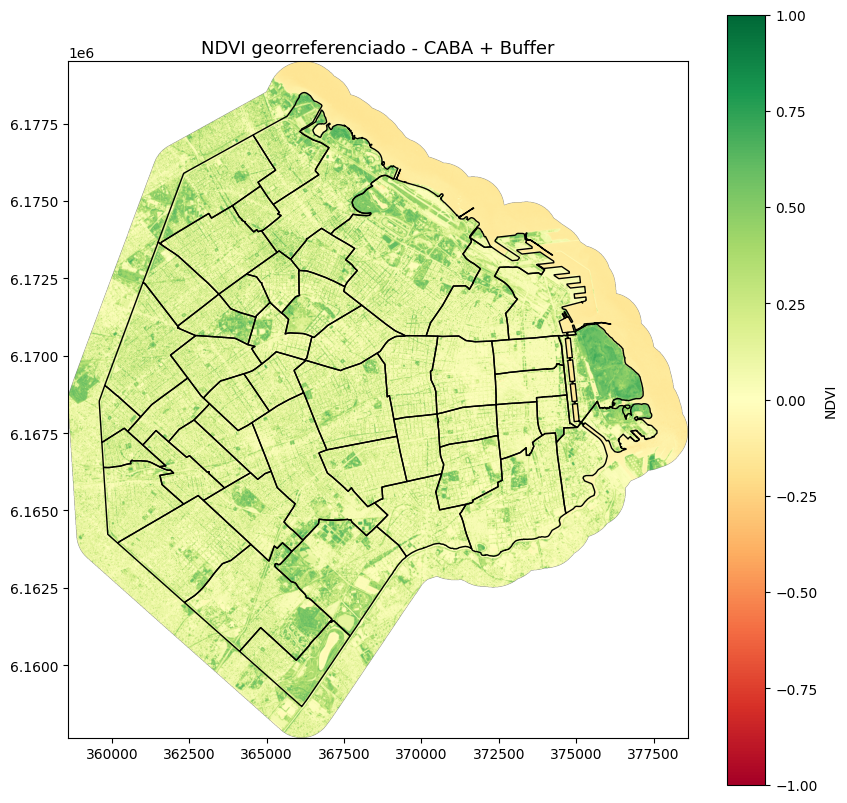

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd

# Paths
S2_B04_CABA_buffer = 'data/S2_B04_CABA_buffer.tif'
S2_B08_CABA_buffer = 'data/S2_B08_CABA_buffer.tif'
barrios = 'data/barrios.shp'

# Leer shapefile
barrios_gdf = gpd.read_file(barrios)

# Calcular NDVI con georreferencia
with rasterio.open(S2_B04_CABA_buffer) as red_src, rasterio.open(S2_B08_CABA_buffer) as nir_src:
    b4 = red_src.read(1).astype('float32')
    b8 = nir_src.read(1).astype('float32')
    ndvi = np.where((b8 + b4) == 0, np.nan, (b8 - b4) / (b8 + b4))
    extent = rasterio.plot.plotting_extent(red_src)
    raster_crs = red_src.crs

# Reproyectar barrios
if barrios_gdf.crs != raster_crs:
    barrios_gdf = barrios_gdf.to_crs(raster_crs)

# Mostrar NDVI georreferenciado
fig, ax = plt.subplots(figsize=(10,10))
ndvi_plot = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, extent=extent)
barrios_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
plt.colorbar(ndvi_plot, ax=ax, label="NDVI")
ax.set_title("NDVI georreferenciado - CABA + Buffer", fontsize=13)
plt.show()